In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install pyspark
# Get the file from your Google Drive
file_path = '/content/drive/My Drive/502a2q6/toydata.csv'

from pyspark import SparkContext
from pyspark.sql import SparkSession
# Create an instance of SparkContext
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
threshhold = 0.2
df = spark.read.csv(file_path, header=True, inferSchema=False)


In [ ]:

from pyspark.sql.functions import split
df = df.withColumn('friends', split(df['friends'], ','))
print(df)


DataFrame[UserID: string, friends: array<string>]


In [ ]:
df.take(3)

[Row(UserID='1', friends=['72', '18', '7']),
 Row(UserID='2', friends=['3', '7', '9', '13', '16', '83', '20']),
 Row(UserID='3', friends=['2', '4', '5', '38', '7', '6', '11', '29', '19', '59', '61'])]

In [ ]:
 #Import necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
network_rdd = df.rdd



In [ ]:
kv_rdd = network_rdd.map(lambda x:(int(x[0]), [int(each) for each in x[1]] if x[1] else [])).collect()


In [ ]:
kv_rdd2 = sc.parallelize(kv_rdd)

In [ ]:
def pcss_mapper(edge):
    node, neighbors = edge
    for neighbor in neighbors:
        yield ((min(node, neighbor), max(node, neighbor)), neighbors)

pcss_mapped = kv_rdd2.flatMap(pcss_mapper)


In [ ]:
pcss_mapped.take(5)

[((1, 72), [72, 18, 7]),
 ((1, 18), [72, 18, 7]),
 ((1, 7), [72, 18, 7]),
 ((2, 3), [3, 7, 9, 13, 16, 83, 20]),
 ((2, 7), [3, 7, 9, 13, 16, 83, 20])]

In [ ]:
def calculate_structural_similarity(adjacency_list1, adjacency_list2):
    set1 = set(adjacency_list1)
    set2 = set(adjacency_list2)

    intersection = set1.intersection(set2)
    union = set1.union(set2)

    if not union:
        return 0  # Avoid division by zero
    jaccard_similarity = len(intersection) / len(union)

    return jaccard_similarity

In [ ]:
def pcss_reducer(adjacency_lists):
    global threshhold
    adjacency_lists = list(adjacency_lists)
    if len(adjacency_lists) == 2:
        adjacency_list1, adjacency_list2 = adjacency_lists
        structural_similarity = calculate_structural_similarity(adjacency_list1, adjacency_list2)
    else:
        structural_similarity = 0
    if structural_similarity > threshhold:
      return structural_similarity
    else:
      return None

pcss_reduced = pcss_mapped.groupByKey().mapValues(pcss_reducer).filter(lambda x: x[1] is not None)



In [ ]:
pcss_reduced.take(10)

[((3, 19), 0.23529411764705882),
 ((5, 19), 0.26666666666666666),
 ((14, 20), 0.25),
 ((21, 39), 0.21428571428571427),
 ((24, 34), 0.23076923076923078),
 ((30, 32), 0.25),
 ((31, 37), 0.25),
 ((46, 60), 0.3333333333333333),
 ((63, 65), 0.21428571428571427),
 ((81, 85), 0.23076923076923078)]

In [ ]:

pruned_neighbors_rdd = (pcss_reduced
                        .flatMap(lambda x: [(x[0][0], x[0][1]), (x[0][1], x[0][0])])
                        .distinct()
                        .groupByKey()
                        .mapValues(list))

updated_kv_rdd = kv_rdd2.leftOuterJoin(pruned_neighbors_rdd)

updated_kv_rdd = updated_kv_rdd.mapValues(lambda x: x[1] if x[1] is not None else [])
sorted_kv_rdd = updated_kv_rdd.sortByKey()

In [ ]:
sorted_kv_rdd.take(5)

[(1, []), (2, []), (3, [19]), (4, []), (5, [19, 10])]

LPCC

In [ ]:
# initialize each node with its own ID as the label and mark it as status
lpcc_rdd = sorted_kv_rdd.map(lambda x: (x[0], {'label': x[0], 'neighbors': x[1], 'status': True}))


In [ ]:
from pyspark import SparkContext
sc = SparkContext.getOrCreate()

def lpcc_mapper(node):
    yield (node[0], (node[1], 'state'))

    if node[1]['status']:
        for neighbor in node[1]['neighbors']:
            yield (neighbor, (node[1]['label'], 'label'))

def lpcc_reducer(values):
    current_state = None
    min_label = float('inf')

    for value, valueType in values:
        if valueType == 'state':
            current_state = value
        elif valueType == 'label':
            min_label = min(min_label, value)

    if min_label < current_state['label']:
        return {'label': min_label, 'neighbors': current_state['neighbors'], 'status': True}
    else:
        return {'label': current_state['label'], 'neighbors': current_state['neighbors'], 'status': False}

# loop until no more updates
while True:
    propagated_labels = lpcc_rdd.flatMap(lpcc_mapper)

    updated_lpcc_rdd = (propagated_labels
                        .groupByKey()
                        .mapValues(lpcc_reducer))

    any_updates = updated_lpcc_rdd.filter(lambda x: x[1]['status']).count() > 0

    lpcc_rdd = updated_lpcc_rdd

    if not any_updates:
        break  # Exit



In [ ]:
lpcc_rdd.sortByKey().take(10)

[(1, {'label': 1, 'neighbors': [], 'status': False}),
 (2, {'label': 2, 'neighbors': [], 'status': False}),
 (3, {'label': 3, 'neighbors': [19], 'status': False}),
 (4, {'label': 4, 'neighbors': [], 'status': False}),
 (5, {'label': 3, 'neighbors': [19, 10], 'status': False}),
 (6, {'label': 6, 'neighbors': [15], 'status': False}),
 (7, {'label': 7, 'neighbors': [], 'status': False}),
 (8, {'label': 8, 'neighbors': [], 'status': False}),
 (9, {'label': 9, 'neighbors': [], 'status': False}),
 (10, {'label': 3, 'neighbors': [5], 'status': False})]

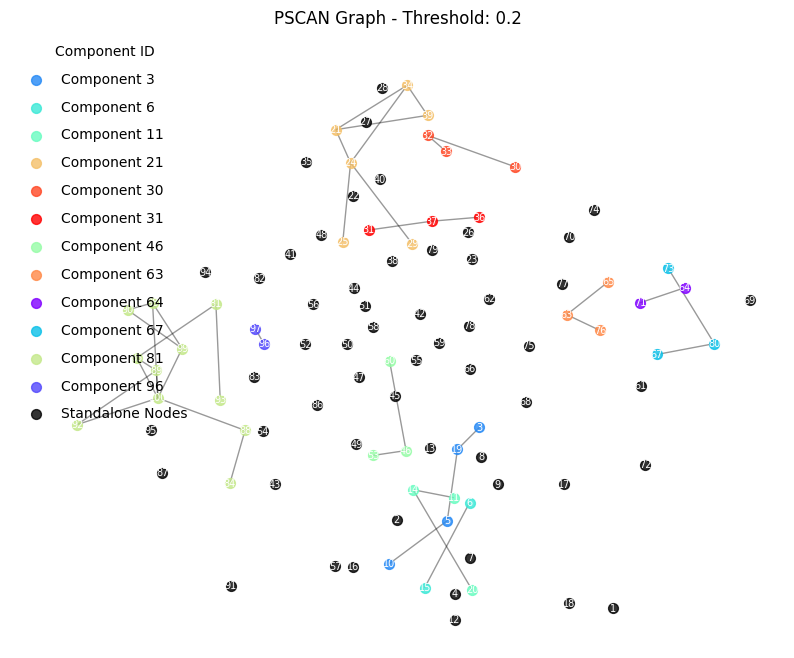

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

final_nodes = lpcc_rdd.sortByKey().collect()

G2 = nx.Graph()
label_to_nodes = {}
standalone_nodes = []

for node, data in final_nodes:
    G2.add_node(node, label=data['label'])
    if data['neighbors']:  # If the node has neighbors
        label_to_nodes.setdefault(data['label'], []).append(node)
    else:  # Node is standalone
        standalone_nodes.append(node)
    for neighbor in data['neighbors']:
        G2.add_edge(node, neighbor)

unique_labels = set(label for label, nodes in label_to_nodes.items() if nodes)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
label_to_color = dict(zip(unique_labels, colors))

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G2, pos, alpha=0.4)

for label, nodes in label_to_nodes.items():
    nx.draw_networkx_nodes(G2, pos,
                           nodelist=nodes,
                           node_color=[label_to_color[label]],
                           label=f"Component {label}",
                           node_size=50,
                           alpha=0.8)

nx.draw_networkx_nodes(G2, pos,
                       nodelist=standalone_nodes,
                       node_color="black",
                       node_size=50,
                       alpha=0.8,
                       label="Standalone Nodes")

nx.draw_networkx_labels(G2, pos, font_size=7, font_color='white')

plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Component ID')
plt.title(f"PSCAN Graph - Threshold: {threshhold}")
plt.axis('off')
plt.show()


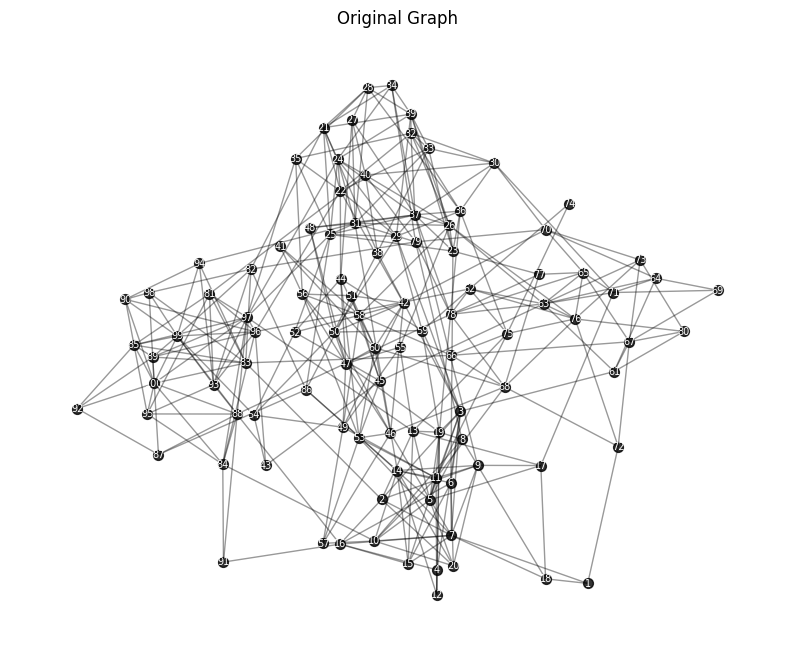

In [ ]:
G = nx.Graph()

for node, neighbors in kv_rdd:
    G.add_node(node)
    for neighbor in neighbors:
        G.add_edge(node, neighbor)

try:
    pos
except NameError:
    pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(10, 8))
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_nodes(G, pos, node_color='black', node_size=50, alpha=0.8)
nx.draw_networkx_labels(G, pos, font_size=7, font_color='white')

plt.title("Original Graph")
plt.axis('off')
plt.show()

In [ ]:
print(G.number_of_edges())


349
